# Predicción de Series Temporales NN - Multivariate

## Usaremos Keras y Tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Cargamos nuestro Dataset

In [2]:
df = pd.read_csv('Prueba_Id.csv', parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2018-05-23,3
2018-05-25,3
2018-05-29,2
2018-06-08,1
2018-06-11,2


In [3]:
print(df.index.min())
print(df.index.max())

2018-05-23 00:00:00
2019-06-21 00:00:00


In [4]:
print(len(df['2018']))
print(len(df['2019']))

125
145


### Cargamos Datos Categóricos: Día y Mes

In [5]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2018-05-23,3,2,5
2018-05-25,3,4,5
2018-05-29,2,1,5
2018-06-08,1,4,6
2018-06-11,2,0,6


In [6]:
df.describe()

,unidades,weekday,month
count,270.000000,270.000000,270.000000
mean,15.111111,2.855556,5.877778
std,27.726000,1.935163,3.459251
min,1.000000,0.000000,1.000000
25%,2.000000,1.000000,3.000000
50%,5.000000,3.000000,6.000000
75%,12.750000,4.000000,9.000000
max,180.000000,6.000000,12.000000


## Preprocesado de los datos

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-06-15,2.0,5.0,-0.977654,4.0,5.0,-0.977654,1.0,5.0,-0.988827,4.0,...,-0.988827,1.0,6.0,-0.977654,3.0,6.0,-1.000000,4,6,-1.000000
2018-06-16,4.0,5.0,-0.977654,1.0,5.0,-0.988827,4.0,6.0,-1.000000,0.0,...,-0.977654,3.0,6.0,-1.000000,4.0,6.0,-1.000000,5,6,-1.000000
2018-06-17,1.0,5.0,-0.988827,4.0,6.0,-1.000000,0.0,6.0,-0.988827,1.0,...,-1.000000,4.0,6.0,-1.000000,5.0,6.0,-1.000000,6,6,-1.000000
2018-06-18,4.0,6.0,-1.000000,0.0,6.0,-0.988827,1.0,6.0,-0.977654,3.0,...,-1.000000,5.0,6.0,-1.000000,6.0,6.0,-1.000000,0,6,-0.955307
2018-06-19,0.0,6.0,-0.988827,1.0,6.0,-0.977654,3.0,6.0,-1.000000,4.0,...,-1.000000,6.0,6.0,-1.000000,0.0,6.0,-0.955307,1,6,-0.977654


## Dividimos en set de Entrenamiento y Validación

In [9]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(263, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-06-15,2.0,5.0,-0.977654,4.0,5.0,-0.977654,1.0,5.0,-0.988827,4.0,...,0.0,6.0,-0.988827,1.0,6.0,-0.977654,3.0,6.0,-1.000000,-1.000000
2018-06-16,4.0,5.0,-0.977654,1.0,5.0,-0.988827,4.0,6.0,-1.000000,0.0,...,1.0,6.0,-0.977654,3.0,6.0,-1.000000,4.0,6.0,-1.000000,-1.000000
2018-06-17,1.0,5.0,-0.988827,4.0,6.0,-1.000000,0.0,6.0,-0.988827,1.0,...,3.0,6.0,-1.000000,4.0,6.0,-1.000000,5.0,6.0,-1.000000,-1.000000
2018-06-18,4.0,6.0,-1.000000,0.0,6.0,-0.988827,1.0,6.0,-0.977654,3.0,...,4.0,6.0,-1.000000,5.0,6.0,-1.000000,6.0,6.0,-1.000000,-0.955307
2018-06-19,0.0,6.0,-0.988827,1.0,6.0,-0.977654,3.0,6.0,-1.000000,4.0,...,5.0,6.0,-1.000000,6.0,6.0,-1.000000,0.0,6.0,-0.955307,-0.977654


In [10]:
# split into train and test sets
values = newReframed.values
n_train_days = 261 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(224, 1, 21) (224,) (39, 1, 21) (39,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward

#### Como entradas son 21 columnas (7 pasos por 3 variables)

In [11]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

## Entrenamiento y Resultados

In [12]:
# En pocos segundos vemos una reducción del valor de pérdida tanto del set de entrenamiento como del de validación. 
# original EPOCHS = 40, luego voy modificando
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

W0826 01:32:26.453045  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 01:32:26.593045  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 01:32:26.609045  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 01:32:26.909417  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


W0826 01:32:27.676600  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 01:32:28.140291  1548 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 224 samples, validate on 39 samples
Epoch 1/40
224/224 [==============================] - 4s 18ms/step - loss: 0.3605 - mean_squared_error: 0.3781 - val_loss: 0.3064 - val_mean_squared_error: 0.3191
Epoch 2/40
224/224 [==============================] - 0s 2ms/step - loss: 0.2090 - mean_squared_error: 0.1649 - val_loss: 0.3115 - val_mean_squared_error: 0.3239
Epoch 3/40
224/224 [==============================] - 0s 2ms/step - loss: 0.1600 - mean_squared_error: 0.1082 - val_loss: 0.3123 - val_mean_squared_error: 0.3247
Epoch 4/40
224/224 [==============================] - 1s 3ms/step - loss: 0.1391 - mean_squared_error: 0.0911 - val_loss: 0.3125 - val_mean_squared_error: 0.3249
Epoch 5/40
224/224 [==============================] - 1s 3ms/step - loss: 0.1320 - mean_squared_error: 0.0875 - val_loss: 0.3125 - val_mean_squared_error: 0.3250
Epoch 6/40
224/224 [==============================] - 1s 2ms/step - loss: 0.1303 - mean_squared_error: 0.0869 - val_loss: 0.3126 - val_mean_squa

## Visualizamos Resultados

39


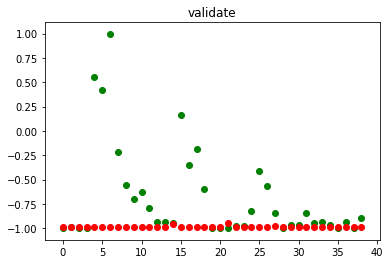

In [13]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más

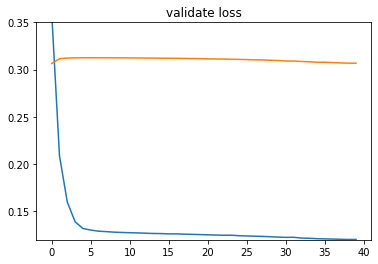

In [14]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Modelo 2) STMV: En azul el Entrenamiento y naranja el set de Validación

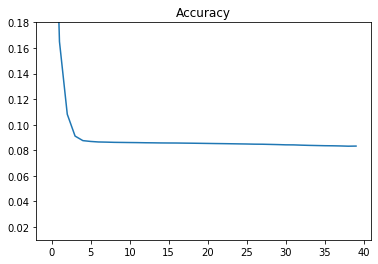

In [15]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [16]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,1.000000,2.255913,-1.255913
1,2.000001,2.251789,-0.251789
2,1.000000,2.245468,-1.245467
3,1.000000,2.247783,-1.247783
4,140.000005,2.517544,137.482461
5,128.000000,2.236980,125.763020
6,179.999990,2.430467,177.569523
7,70.999998,2.261125,68.738873
8,41.000001,2.234601,38.765400
9,28.000001,2.244209,25.755792


In [17]:
compara2.describe()

,real,prediccion,diferencia
count,39.000000,39.000000,39.000000
mean,29.153846,2.457980,26.695866
std,43.331972,0.696761,43.409665
min,1.000000,2.234601,-4.562201
25%,2.500001,2.239416,0.219527
50%,6.999998,2.251789,4.764063
75%,38.500000,2.317616,36.257984
max,179.999990,5.562201,177.569523


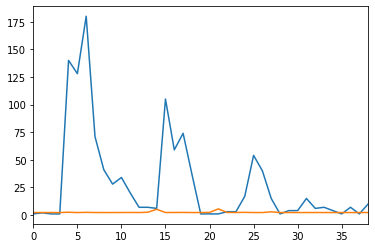

In [18]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

In [19]:
ultimosDias = df['2019-05-16':'2019-05-31']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2019-05-16,71,3,5,-0.217877
2019-05-17,41,4,5,-0.553073
2019-05-18,28,5,5,-0.698324
2019-05-19,34,6,5,-0.631285
2019-05-20,20,0,5,-0.787709
2019-05-21,7,1,5,-0.932961
2019-05-22,7,2,5,-0.932961
2019-05-23,6,3,5,-0.944134
2019-05-24,105,4,5,0.162011


## Preparamos los datos para Test

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida «Y» pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [20]:
scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 3.          5.         -0.21787709]
 [ 4.          5.         -0.55307257]
 [ 5.          5.         -0.69832397]
 [ 6.          5.         -0.63128483]
 [ 0.          5.         -0.78770947]
 [ 1.          5.         -0.93296087]
 [ 2.          5.         -0.93296087]
 [ 3.          5.         -0.944134  ]
 [ 4.          5.          0.16201115]
 [ 5.          5.         -0.35195529]
 [ 6.          5.         -0.18435752]
 [ 0.          5.         -0.59776533]
 [ 1.          5.         -0.99999994]
 [ 2.          5.         -0.99999994]
 [ 4.          5.         -0.99999994]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-05-23,3.0,5.0,-0.217877,4.0,5.0,-0.553073,5.0,5.0,-0.698324,6.0,...,-0.631285,0.0,5.0,-0.787709,1.0,5.0,-0.932961,2.0,5.0,-0.932961
2019-05-24,4.0,5.0,-0.553073,5.0,5.0,-0.698324,6.0,5.0,-0.631285,0.0,...,-0.787709,1.0,5.0,-0.932961,2.0,5.0,-0.932961,3.0,5.0,-0.944134
2019-05-25,5.0,5.0,-0.698324,6.0,5.0,-0.631285,0.0,5.0,-0.787709,1.0,...,-0.932961,2.0,5.0,-0.932961,3.0,5.0,-0.944134,4.0,5.0,0.162011
2019-05-26,6.0,5.0,-0.631285,0.0,5.0,-0.787709,1.0,5.0,-0.932961,2.0,...,-0.932961,3.0,5.0,-0.944134,4.0,5.0,0.162011,5.0,5.0,-0.351955
2019-05-27,0.0,5.0,-0.787709,1.0,5.0,-0.932961,2.0,5.0,-0.932961,3.0,...,-0.944134,4.0,5.0,0.162011,5.0,5.0,-0.351955,6.0,5.0,-0.184358
2019-05-28,1.0,5.0,-0.932961,2.0,5.0,-0.932961,3.0,5.0,-0.944134,4.0,...,0.162011,5.0,5.0,-0.351955,6.0,5.0,-0.184358,0.0,5.0,-0.597765
2019-05-29,2.0,5.0,-0.932961,3.0,5.0,-0.944134,4.0,5.0,0.162011,5.0,...,-0.351955,6.0,5.0,-0.184358,0.0,5.0,-0.597765,1.0,5.0,-1.000000


De este conjunto «ultimosDias» tomamos sólo la última fila, pues es la que correspondería a la última semana de Mayo y la dejamos en el formato correcto para la red neuronal con reshape:

In [21]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(2, 1, 21)
[[[ 2.          5.         -0.93296087  3.          5.
   -0.944134    4.          5.          0.16201115  5.
    5.         -0.35195529  6.          5.         -0.18435752
    0.          5.         -0.59776533  1.          5.
   -0.99999994]]

 [[ 3.          5.         -0.944134    4.          5.
    0.16201115  5.          5.         -0.35195529  6.
    5.         -0.18435752  0.          5.         -0.59776533
    1.          5.         -0.99999994  2.          5.
   -0.99999994]]]


Ahora crearemos una función para ir «rellenando» el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de Junio. Entonces para el 1 de Junio, ya tenemos el set con los últimos 7 días de Mayo. Pero para pronosticar el 2 de Junio necesitamos los 7 días anteriores que INCLUYEN al 1 de Junio y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de Junio.

In [22]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [23]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 2.          5.         -0.93296087  3.          5.
   -0.944134    4.          5.          0.16201115  5.
    5.         -0.35195529  6.          5.         -0.18435752
    0.          5.         -0.59776533  1.          5.
   -0.99999994]]

 [[ 3.          5.         -0.944134    4.          5.
    0.16201115  5.          5.         -0.35195529  6.
    5.         -0.18435752  0.          5.         -0.59776533
    1.          5.         -0.99999994  2.          5.
   -0.99999994]]]
pred 1 [[[ 3.          5.         -0.944134    4.          5.
    0.16201115  5.          5.         -0.35195529  6.
    5.         -0.18435752  0.          5.         -0.59776533
    1.          5.         -0.99999994  5.         12.
   -0.98483449]]

 [[ 3.          5.         -0.944134    4.          5.
    0.16201115  5.          5.         -0.35195529  6.
    5.         -0.18435752  0.          5.         -0.59776533
    1.          5.         -0.99999994  2.          5.
   -0.99999994]]]
pr

## Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala «real» de unidades vendidas. Entonces vamos a «re-transformar» los datos con el objeto «scaler» que creamos antes.

In [24]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.9848345], dtype=float32), array([-0.9856012], dtype=float32), array([-0.9860023], dtype=float32), array([-0.985957], dtype=float32), array([-0.98618495], dtype=float32), array([-0.98616856], dtype=float32), array([-0.9861985], dtype=float32)]


array([[2.35730807],
       [2.28868891],
       [2.25278694],
       [2.25684125],
       [2.23644168],
       [2.2379087 ],
       [2.23523072]])

## Visualizamos el pronóstico

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

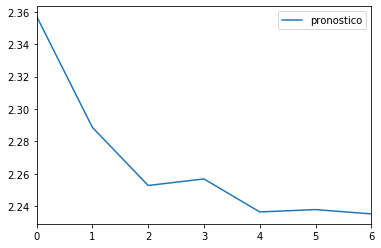

In [25]:
prediccion1SemanaJunio = pd.DataFrame(inverted)
prediccion1SemanaJunio.columns = ['pronostico']
prediccion1SemanaJunio.plot()
prediccion1SemanaJunio.to_csv('pronostico_multivariate_I.csv')

In [26]:
prediccion1SemanaJunio

,pronostico
0,2.357308
1,2.288689
2,2.252787
3,2.256841
4,2.236442
5,2.237909
6,2.235231


A partir de los últimos 7 días de Mayo 2019 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de unidades para la primer semana de Junio.

Para Probar, alterando parámetros del ejercicio:

Variar la cantidad de EPOCHS Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate. Cambiar la arquitectura de la Red Neuronal: Cambiar la cantidad de Neuronas de la capa oculta. Agregar más capas ocultas Probar utilizando más de 7 días previos para predecir. O probar con menos días. Se puede intentar predecir más de 1 día por vez (sin iterar el resultado como hice con la función agregarNuevoValor() )

## Agregamos el resultado en el dataset

In [27]:
i=0
for fila in prediccion1SemanaJunio.pronostico:
    i=i+1
    ultimosDias.loc['2019-06-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

2.3573080694817046
2.2886889056243938
2.252786940860365
2.256841248916927
2.2364416778533838
2.2379086972159556
2.235230720052279


C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,unidades,weekday,month,scaled
fecha,,,,
2019-05-24 00:00:00,105.000000,4.000000,5.000000,0.162011
2019-05-25 00:00:00,59.000000,5.000000,5.000000,-0.351955
2019-05-26 00:00:00,74.000000,6.000000,5.000000,-0.184358
2019-05-27 00:00:00,37.000000,0.000000,5.000000,-0.597765
2019-05-28 00:00:00,1.000000,1.000000,5.000000,-1.000000
2019-05-29 00:00:00,1.000000,2.000000,5.000000,-1.000000
2019-05-31 00:00:00,1.000000,4.000000,5.000000,-1.000000
2019-06-01 00:00:00,2.357308,2.357308,2.357308,2.357308
2019-06-02 00:00:00,2.288689,2.288689,2.288689,2.288689
